<table style="width:100%; border-collapse: collapse;">
    <tr>
        <td style="width: 30%; text-align: center;">
            <img src="https://s3.amazonaws.com/media-p.slid.es/uploads/1485763/images/9060062/Header.png" width="300" alt="Header Image"/>
        </td>
        <td style="width: 5%;"></td>
        <td style="width: 35%; text-align: center;">
            <h1 style="font-size: 250%; color: #004aad; margin: 0;">
                Taller 2
            </h1>
        </td>
        <td style="width: 30%; text-align: left; vertical-align: middle;">
            <p style="font-size: 110%; text-align: center; margin: 5px 0;">Aplicaciones de ML</p>
            <p style="font-size: 120%; text-align: center; margin: 5px 0;">Maestría MACC</p>
            <p style="font-size: 120%; text-align: center; margin: 5px 0;">
                Estudiantes: 
                <b style="color: #d9534f;">Leandro Sánchez Quiroga</b>, 
                <b style="color: #d9534f;">Leonardo Vargas</b> 
            </p>
        </td>
    </tr>
</table>

## Clasificación de Género Cinematográfico a Partir de Sinopsis

En este proyecto exploramos el uso de modelos estadísticos para representar textos en lenguaje natural mediante técnicas de modelado de tópicos, con el objetivo final de clasificar películas según su género. A partir del dataset **The Movies Dataset** de Kaggle, que contiene metadatos de más de 45.000 películas, desarrollamos un pipeline completo que incluye:

- **Preprocesamiento del texto** (sinopsis) usando spaCy.
- **Filtrado del dataset** para quedarnos únicamente con películas que tienen un solo género asignado.
- **Vectorización del texto** utilizando *Supervised Latent Dirichlet Allocation (sLDA)*.
- **Entrenamiento de modelos supervisados** para predecir si una película pertenece al género *Drama*.
- **Evaluación del desempeño del modelo** y análisis de resultados.

### Herramientas utilizadas

- `pandas`, `numpy` y `matplotlib` para manejo de datos y visualización.
- `spaCy` para el procesamiento de lenguaje natural.
- `tomotopy` para el modelado supervisado de tópicos (sLDA).
- `scikit-learn` para la división de conjuntos, evaluación de modelos y clasificación.
- Funciones personalizadas en `utils.py` para modularizar el código y mantener una arquitectura clara y reutilizable.


In [1]:
from utils import *
import pandas as pd
import os
import pandas as pd
import numpy as np
import seaborn as sns
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tomotopy as tp
! python -m spacy download en_core_web_sm

c:\Users\jlvar\OneDrive - Universidad del rosario\001 - MMACC\2025-1\002 - Aplicaicones ML\Tarea 2\Tarea2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --- ------------------------------------ 1.0/12.8 MB 5.6 MB/s eta 0:00:03
     -------- ------------------------------- 2.6/12.8 MB 7.6 MB/s eta 0:00:02
     ------------ --------------------------- 3.9/12.8 MB 6.5 MB/s eta 0:00:02
     ---------------- ----------------------- 5.2/12.8 MB 6.5 MB/s eta 0:00:02
     -------------------- ------------------- 6.6/12.8 MB 6.4 MB/s eta 0:00:01
     -------------------------- ------------- 8.4/12.8 MB 6.8 MB/s eta 0:00:01
     ------------------------------- -------- 10.0/12.8 MB 7.1 MB/s eta 0:00:01
     ------------------------------------- -- 12.1/12.8 MB 7.2 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 7.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


### Carga y preparación del conjunto de datos

En esta celda se ejecuta la función `generar_datos_entrenamiento()`, la cual realiza la limpieza y estructuración del dataset original descargado desde Kaggle. Si el data set no se ha descargado se crea una nueva carpeta y se descarga en ella la información, en el caso de que ya este el data set solo lo carga.




In [2]:
movies, tabla_generos = generar_datos_entrenamiento()
print(f"Número de películas finales: {len(movies)}")
print(f"Número de géneros: {len(tabla_generos)}")
movies.head()

Los archivos ya están descargados en la carpeta 'Data'.
Número de películas finales: 14136
Número de géneros: 20


,title,overview,genre_id,genre_name
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,35,Comedy
25,Othello,The evil Iago pretends to be friend of Othello...,18,Drama
35,Dead Man Walking,A justice drama based on a true story about a ...,18,Drama
39,"Cry, the Beloved Country",A South-African preacher goes to search for hi...,18,Drama
54,Georgia,"Sadie looks up to her older sister Georgia, a ...",18,Drama


### Preprocesamiento del texto con spaCy

En esta celda se realiza el preprocesamiento de la columna `overview`, aplicando la función `preprocesar_texto()` definida en `utils.py`. Esta función utiliza **spaCy** para realizar las siguientes tareas sobre cada sinopsis:

- Conversión a minúsculas.
- Eliminación de puntuación, stopwords, números y caracteres no deseados.
- Tokenización y lematización.
- Filtrado por categorías gramaticales (solo sustantivos, adjetivos y verbos en infinitivo).
- Generación de una lista limpia de tokens por cada película.

El resultado se almacena en una nueva columna llamada `Overview_procesado`, que contiene listas de palabras ya listas para ser usadas en el modelado.

> ⚠️ **Advertencia:** esta celda puede tardar varios minutos en ejecutarse, ya que el procesamiento con spaCy se realiza sin vectorización previa, sobre miles de registros.

Para evitar repetir este paso innecesariamente, los resultados se guardan en el archivo `movies_procesado.csv`.  
**Si ya está ese archivo, no se recomienda volver a ejecutar esta celda.**  
En su lugar, pasar directamente a la siguiente celda, donde se carga el CSV y se retransforma la columna `Overview_procesado` para recuperar su estructura de lista.


In [ ]:
movies['Overview_procesado'] = movies['overview'].apply(preprocesar_texto)
movies.to_csv("movies_procesado.csv", index=False, encoding='utf-8')

### Carga de datos preprocesados y limpieza adicional

En esta celda se carga el archivo `movies_procesado.csv`, previamente generado tras aplicar el preprocesamiento con spaCy. Este archivo contiene una columna llamada `Overview_procesado` que, al momento de guardarse, quedó almacenada como una cadena de texto con formato de lista.

Para recuperar la estructura original de listas de palabras, se realiza lo siguiente:

1. **Conversión con `ast.literal_eval`**: esta función transforma el texto que representa una lista (ej. `"['film', 'drama']"`) nuevamente en una lista Python real (`['film', 'drama']`).
2. **Limpieza adicional de palabras**: se aplica la función `limpiar_palabra()` sobre cada token para eliminar residuos de puntuación u otros caracteres especiales que hayan quedado en el proceso anterior.

> ✅ Esta celda permite continuar el flujo de trabajo sin necesidad de reprocesar todo el texto desde cero, ahorrando tiempo y recursos computacionales.


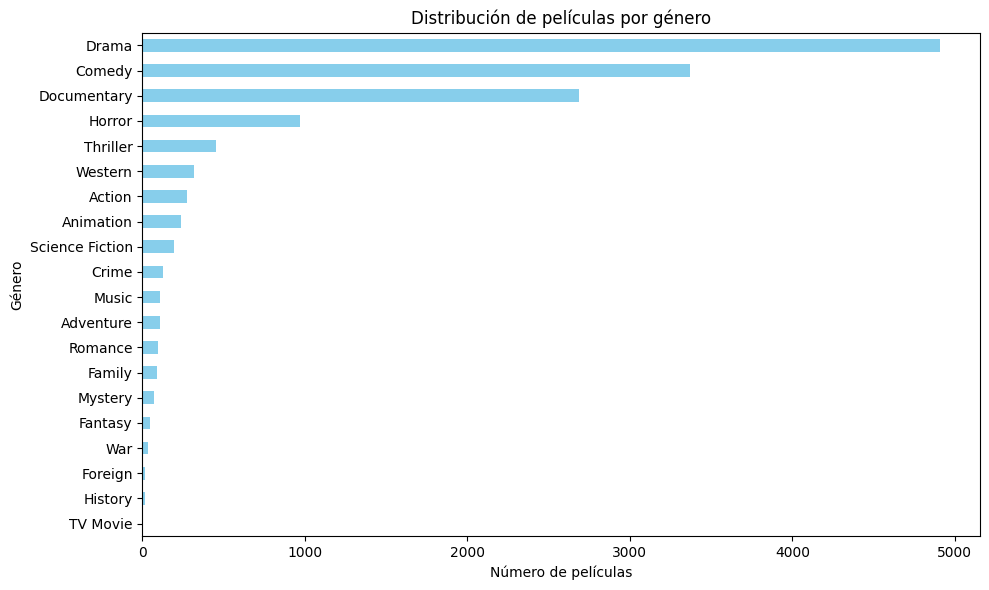

In [3]:
movies = pd.read_csv("movies_procesado.csv")
movies['Overview_procesado'] = movies['Overview_procesado'].apply(ast.literal_eval)
# Aplicar limpieza a cada lista de palabras
movies['Overview_procesado'] = movies['Overview_procesado'].apply(
    lambda lista: [limpiar_palabra(palabra) for palabra in lista]
)
movies.head()
graficar_frecuencia_generos(movies)

### Definición de variable objetivo y partición del conjunto de datos

En esta celda se prepara el conjunto de datos para el entrenamiento del modelo supervisado:

1. **Creación de la variable `y_real`**: se define una variable binaria que indica si una película pertenece al género *Drama* (`genre_id == 18`). Si es así, `y_real` toma el valor `1`; en caso contrario, `0`.

2. **Selección de columnas relevantes**: se crea el DataFrame `datos` con únicamente dos columnas: `Overview_procesado` (lista de palabras de la sinopsis preprocesada) y `y_real`.

3. **Partición del dataset**:
   - Se utiliza `train_test_split` para dividir los datos en dos subconjuntos:
     - 70% para entrenamiento (`movies_train`)
     - 30% para validación (`movies_val`)
   - Se emplea `stratify` sobre `y_real` para asegurar que la proporción de clases (Drama vs. no Drama) se mantenga en ambas particiones.

4. **Conversión a listas para modelado**:
   - `documentos`: lista de sinopsis del conjunto de entrenamiento, cada una como lista de tokens.
   - `genero`: lista de etiquetas binarias (`y_real`) correspondientes a cada sinopsis.


In [4]:
movies['y_real'] = movies['genre_id'].apply(lambda x: 1 if x == 18 else 0)
datos = movies[['Overview_procesado', 'y_real']].dropna()
movies_train, movies_val = train_test_split(
    datos,
    test_size=0.3,
    random_state=42,
    stratify=movies['y_real'] 
)
documentos = movies_train.Overview_procesado.tolist()
genero = movies_train.y_real.tolist()

### Entrenamiento y análisis del modelo supervisado S-LDA (binario)

En esta celda se realiza el entrenamiento y análisis de un modelo **Supervised Latent Dirichlet Allocation (sLDA)** para la tarea de clasificación binaria (*Drama* vs. *no Drama*) a partir de las sinopsis preprocesadas de las películas. El flujo de trabajo es el siguiente:

1. **Inicialización del modelo**:
   - Se crea una instancia de `SLDAModel` de la librería `tomotopy` con los siguientes parámetros:
     - `k=10`: número de tópicos latentes a aprender.
     - `seed=123`: semilla para asegurar reproducibilidad.
     - `vars='b'`: especifica que la variable objetivo es binaria.

2. **Adición de documentos**:
   - Se agregan los documentos de entrenamiento (`documentos`), junto con sus etiquetas binarias (`genero`), al modelo mediante el método `add_doc()`.

3. **Entrenamiento**:
   - El modelo se entrena durante 2000 iteraciones usando el método `train()`, aprendiendo simultáneamente la estructura temática de los textos y la relación de los tópicos con la variable objetivo.

4. **Exploración de los tópicos aprendidos**:
   - Se imprime el top 5 de palabras más representativas para cada uno de los 10 tópicos, lo que permite interpretar los temas latentes descubiertos por el modelo.

5. **Análisis de los coeficientes de regresión**:
   - Se extraen e imprimen los coeficientes de regresión asociados a cada tópico, que indican la influencia de cada tema en la predicción de la clase positiva (*Drama*).

6. **Predicción sobre un ejemplo de validación**:
   - Se selecciona un documento del conjunto de validación y se transforma al formato requerido por el modelo.
   - Se imprime la sinopsis procesada, la etiqueta real y la distribución de tópicos inferida para ese documento.
   - Se estima la probabilidad de que el documento pertenezca al género *Drama* y se imprime la predicción junto con la probabilidad calculada.




In [5]:
# Entrenamiento y análisis del modelo supervisado S-LDA (binario)

# 1. Inicialización del modelo S-LDA para clasificación binaria (Drama vs. no Drama)
modelo_binario = tp.SLDAModel(k=10, seed=123, vars='b')

# 2. Adición de documentos de entrenamiento y sus etiquetas binarias al modelo
for i in range(len(documentos)):
    modelo_binario.add_doc(words=documentos[i], y=[genero[i]])

# 3. Entrenamiento del modelo durante 2000 iteraciones
modelo_binario.train(2000)

# 4. Impresión de los 5 términos más representativos de cada uno de los 10 tópicos aprendidos
print("\nTemas Aprendidos:")
for k in range(modelo_binario.k):
    print(f"Tema #{k}: {modelo_binario.get_topic_words(k, top_n=5)}")

# 5. Extracción e impresión de los coeficientes de regresión (log-odds) para cada tópico,
#    que indican su influencia en la predicción de la clase positiva (Drama)
coeficientes_regresion_binario = modelo_binario.get_regression_coef(0)
print("\nCoeficientes de Regresión para Sentimiento (Log-Odds):")
for i, coef in enumerate(coeficientes_regresion_binario):
    print(f"Tema #{i}: {coef:.4f}")

# 6. Ejemplo de predicción sobre un documento del conjunto de validación:
#    - Se transforma la sinopsis procesada al formato requerido por el modelo
#    - Se imprime la sinopsis, la etiqueta real, la distribución de tópicos inferida
#    - Se estima la probabilidad de pertenecer al género Drama y se imprime la predicción
exa = 0
doc_inst = modelo_binario.make_doc(movies_val.Overview_procesado.iloc[exa])
print("Documento de prueba:", doc_inst)
print("Género real:", movies_val.y_real.iloc[exa])
topic_dist, _ = modelo_binario.infer(doc_inst)
print("Distribución de los temas", topic_dist)
prob_dist = modelo_binario.estimate(doc_inst)
if prob_dist > 0.5:
    print("Predicción: Género 18 (positivo) ", prob_dist)
else:
    print("Predicción: Género 18 (negativo) ", prob_dist)

C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\3270540886.py:11: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo_binario.train(2000)



Temas Aprendidos:
Tema #0: [('murder', 0.02151600457727909), ('kill', 0.015862708911299706), ('man', 0.01569804921746254), ('find', 0.014984527602791786), ('police', 0.013941685669124126)]
Tema #1: [('woman', 0.03517749533057213), ('love', 0.03171563893556595), ('young', 0.025796979665756226), ('man', 0.016863154247403145), ('fall', 0.016193117946386337)]
Tema #2: [('life', 0.037837643176317215), ('story', 0.01907639019191265), ('world', 0.016636114567518234), ('man', 0.015140462666749954), ('people', 0.008554344065487385)]
Tema #3: [('friend', 0.012114287354052067), ('find', 0.011735724285244942), ('way', 0.009413867257535458), ('money', 0.008934353478252888), ('job', 0.008732452988624573)]
Tema #4: [('war', 0.025239743292331696), ('american', 0.011306805536150932), ('country', 0.00942243356257677), ('political', 0.007994878105819225), ('story', 0.007309651933610439)]
Tema #5: [('comedy', 0.020837005227804184), ('star', 0.015233933925628662), ('play', 0.014825375750660896), ('team', 

### Validación cruzada para selección del número óptimo de tópicos (k)

En esta celda se ejecuta una validación cruzada de 5 folds para determinar el número óptimo de tópicos (`k`) que debe tener el modelo sLDA. Para ello:

1. Se define un rango de valores posibles para `k`, desde 10 hasta 20.
2. Para cada valor de `k`:
   - Se entrena un modelo sLDA con `k` tópicos usando solo el conjunto de entrenamiento.
   - Se realiza una validación cruzada de 5 pliegues:
     - En cada pliegue, se entrena el modelo sobre el 80% de los datos y se evalúa sobre el 20% restante.
     - Se extraen los embeddings temáticos (distribuciones de tópicos).
     - Se entrena un clasificador (regresión logística) y se mide la precisión (`accuracy`) en cada pliegue.
   - Se calcula el promedio de accuracy de los 5 folds y se guarda en un diccionario.

Este proceso permite comparar el desempeño de modelos con diferentes cantidades de tópicos y seleccionar el valor de `k` que ofrece mejor capacidad predictiva.  
El resultado de cada evaluación se imprime en pantalla junto con la precisión promedio correspondiente.



### Evaluación de modelos sLDA para diferentes valores de k

En esta celda se realiza una validación cruzada con 5 *folds* para determinar cuál es el número óptimo de temas (`k`) para el modelo sLDA. Se prueba con valores de `k` desde 10 hasta 20.

Para cada valor de `k`, se entrena un modelo sLDA con los documentos de entrenamiento y se evalúa su capacidad para predecir la etiqueta binaria (`y_real`) usando un clasificador de regresión logística sobre las distribuciones de temas aprendidas. El rendimiento se mide en términos de **accuracy promedio** en los 5 *folds*.

Este procedimiento permite seleccionar el valor de `k` que maximiza el desempeño predictivo del modelo.


In [61]:
valores_k = range(10, 21)
resultados_kfold = {}

for k in valores_k:
    print(f"Evaluando k={k}...")
    acc = validar_kfold_slda_1(k, documentos, genero, folds=5)
    resultados_kfold[k] = acc
    print(f"→ k={k}, accuracy promedio: {acc:.4f}")

Evaluando k=10...
Entrenando modelo con 7912 documentos (fold 1)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 1 accuracy: 0.7115
Entrenando modelo con 7910 documentos (fold 2)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 2 accuracy: 0.7128
Entrenando modelo con 7909 documentos (fold 3)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 3 accuracy: 0.6988
Entrenando modelo con 7911 documentos (fold 4)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 4 accuracy: 0.7294
Entrenando modelo con 7910 documentos (fold 5)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 5 accuracy: 0.6866
→ k=10, accuracy promedio: 0.7078
Evaluando k=11...
Entrenando modelo con 7912 documentos (fold 1)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 1 accuracy: 0.7196
Entrenando modelo con 7910 documentos (fold 2)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 2 accuracy: 0.7230
Entrenando modelo con 7909 documentos (fold 3)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 3 accuracy: 0.6943
Entrenando modelo con 7911 documentos (fold 4)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 4 accuracy: 0.7132
Entrenando modelo con 7910 documentos (fold 5)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 5 accuracy: 0.7022
→ k=11, accuracy promedio: 0.7105
Evaluando k=12...
Entrenando modelo con 7912 documentos (fold 1)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 1 accuracy: 0.7257
Entrenando modelo con 7910 documentos (fold 2)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 2 accuracy: 0.7128
Entrenando modelo con 7909 documentos (fold 3)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 3 accuracy: 0.7115
Entrenando modelo con 7911 documentos (fold 4)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 4 accuracy: 0.7218
Entrenando modelo con 7910 documentos (fold 5)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 5 accuracy: 0.7093
→ k=12, accuracy promedio: 0.7162
Evaluando k=13...
Entrenando modelo con 7912 documentos (fold 1)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 1 accuracy: 0.7105
Entrenando modelo con 7910 documentos (fold 2)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 2 accuracy: 0.7078
Entrenando modelo con 7909 documentos (fold 3)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 3 accuracy: 0.6948
Entrenando modelo con 7911 documentos (fold 4)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 4 accuracy: 0.7167
Entrenando modelo con 7910 documentos (fold 5)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 5 accuracy: 0.6906
→ k=13, accuracy promedio: 0.7041
Evaluando k=14...
Entrenando modelo con 7912 documentos (fold 1)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 1 accuracy: 0.7161
Entrenando modelo con 7910 documentos (fold 2)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 2 accuracy: 0.7083
Entrenando modelo con 7909 documentos (fold 3)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 3 accuracy: 0.7120
Entrenando modelo con 7911 documentos (fold 4)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 4 accuracy: 0.7218
Entrenando modelo con 7910 documentos (fold 5)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 5 accuracy: 0.7022
→ k=14, accuracy promedio: 0.7121
Evaluando k=15...
Entrenando modelo con 7912 documentos (fold 1)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 1 accuracy: 0.7176
Entrenando modelo con 7910 documentos (fold 2)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 2 accuracy: 0.7103
Entrenando modelo con 7909 documentos (fold 3)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 3 accuracy: 0.7014
Entrenando modelo con 7911 documentos (fold 4)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 4 accuracy: 0.7172
Entrenando modelo con 7910 documentos (fold 5)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 5 accuracy: 0.7093
→ k=15, accuracy promedio: 0.7112
Evaluando k=16...
Entrenando modelo con 7912 documentos (fold 1)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 1 accuracy: 0.7126
Entrenando modelo con 7910 documentos (fold 2)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 2 accuracy: 0.7149
Entrenando modelo con 7909 documentos (fold 3)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 3 accuracy: 0.7079
Entrenando modelo con 7911 documentos (fold 4)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 4 accuracy: 0.7152
Entrenando modelo con 7910 documentos (fold 5)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 5 accuracy: 0.6997
→ k=16, accuracy promedio: 0.7101
Evaluando k=17...
Entrenando modelo con 7912 documentos (fold 1)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 1 accuracy: 0.7115
Entrenando modelo con 7910 documentos (fold 2)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 2 accuracy: 0.7144
Entrenando modelo con 7909 documentos (fold 3)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 3 accuracy: 0.7175
Entrenando modelo con 7911 documentos (fold 4)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 4 accuracy: 0.7203
Entrenando modelo con 7910 documentos (fold 5)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 5 accuracy: 0.6967
→ k=17, accuracy promedio: 0.7121
Evaluando k=18...
Entrenando modelo con 7912 documentos (fold 1)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 1 accuracy: 0.7201
Entrenando modelo con 7910 documentos (fold 2)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 2 accuracy: 0.7022
Entrenando modelo con 7909 documentos (fold 3)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 3 accuracy: 0.7069
Entrenando modelo con 7911 documentos (fold 4)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 4 accuracy: 0.7198
Entrenando modelo con 7910 documentos (fold 5)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 5 accuracy: 0.7002
→ k=18, accuracy promedio: 0.7099
Evaluando k=19...
Entrenando modelo con 7912 documentos (fold 1)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 1 accuracy: 0.7085
Entrenando modelo con 7910 documentos (fold 2)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 2 accuracy: 0.7245
Entrenando modelo con 7909 documentos (fold 3)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 3 accuracy: 0.7105
Entrenando modelo con 7911 documentos (fold 4)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 4 accuracy: 0.7076
Entrenando modelo con 7910 documentos (fold 5)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 5 accuracy: 0.6941
→ k=19, accuracy promedio: 0.7090
Evaluando k=20...
Entrenando modelo con 7912 documentos (fold 1)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 1 accuracy: 0.7151
Entrenando modelo con 7910 documentos (fold 2)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 2 accuracy: 0.7103
Entrenando modelo con 7909 documentos (fold 3)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 3 accuracy: 0.7044
Entrenando modelo con 7911 documentos (fold 4)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 4 accuracy: 0.7107
Entrenando modelo con 7910 documentos (fold 5)


C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\4070515058.py:47: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo.train(iteraciones)


Fold 5 accuracy: 0.7073
→ k=20, accuracy promedio: 0.7095


### Entrenamiento final del modelo S-LDA (binario)

Con base en los resultados obtenidos mediante validación cruzada, se seleccionó **k = 20** como el número óptimo de temas para el modelo supervisado S-LDA, dado que arrojó el mejor desempeño promedio en términos de accuracy.

En esta celda se realiza el entrenamiento final del modelo con todos los datos disponibles del conjunto de entrenamiento (`documentos` y `genero`), utilizando 20 temas. Posteriormente, se imprimen los términos más representativos de cada tema y los coeficientes de regresión asociados, los cuales permiten interpretar la relevancia de cada tópico en la predicción del género **Drama**.


In [ ]:
# Entrenamiento y análisis del modelo supervisado S-LDA (binario)

# 1. Inicialización del modelo S-LDA para clasificación binaria (Drama vs. no Drama)
modelo_binario = tp.SLDAModel(k=20, seed=123, vars='b')

# 2. Adición de documentos de entrenamiento y sus etiquetas binarias al modelo
for i in range(len(documentos)):
    modelo_binario.add_doc(words=documentos[i], y=[genero[i]])

# 3. Entrenamiento del modelo durante 2000 iteraciones
modelo_binario.train(5000)

# 4. Impresión de los 5 términos más representativos de cada uno de los 10 tópicos aprendidos
print("\nTemas Aprendidos:")
for k in range(modelo_binario.k):
    print(f"Tema #{k}: {modelo_binario.get_topic_words(k, top_n=5)}")

# 5. Extracción e impresión de los coeficientes de regresión (log-odds) para cada tópico,
#    que indican su influencia en la predicción de la clase positiva (Drama)
coeficientes_regresion_binario = modelo_binario.get_regression_coef(0)
print("\nCoeficientes de Regresión para Sentimiento (Log-Odds):")
for i, coef in enumerate(coeficientes_regresion_binario):
    print(f"Tema #{i}: {coef:.4f}")




Temas Aprendidos:
Tema #0: [('music', 0.032103586941957474), ('band', 0.026106541976332664), ('rock', 0.0176401287317276), ('singer', 0.016052676364779472), ('musician', 0.013583304360508919)]
Tema #1: [('friend', 0.02215372771024704), ('find', 0.016606321558356285), ('day', 0.015844913199543953), ('time', 0.013995777815580368), ('night', 0.012074127793312073)]
Tema #2: [('earth', 0.020057830959558487), ('world', 0.01414191909134388), ('ship', 0.01327617559581995), ('space', 0.012121850624680519), ('crew', 0.011688979342579842)]
Tema #3: [('team', 0.03696401044726372), ('game', 0.02876553125679493), ('world', 0.017787910997867584), ('player', 0.017787910997867584), ('win', 0.017509998753666878)]
Tema #4: [('family', 0.036268819123506546), ('year', 0.027874337509274483), ('young', 0.027515599504113197), ('old', 0.02697749063372612), ('father', 0.026403509080410004)]
Tema #5: [('find', 0.014733745716512203), ('woman', 0.014465875923633575), ('evil', 0.013215815648436546), ('young', 0.01

C:\Users\jlvar\AppData\Local\Temp\ipykernel_38640\1996304035.py:11: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo_binario.train(5000)


### Película de Ejemplo 1

**Título:** The Love Guru  
**Género:** Comedy  
**Overview:**  
Born in America and raised in an Indian ashram, Pitka (Mike Myers) returns to his native land to seek his fortune as a spiritualist and self-help expert. His skills are put to the test when he must get a brokenhearted hockey player's marriage back on track in time for the man to help his team win the Stanley Cup.  

🔗 [Ver en Rotten Tomatoes](https://www.rottentomatoes.com/m/love_guru)

                  

In [63]:
overview_1 = "Born in America and raised in an Indian ashram, Pitka (Mike Myers) returns to his native land to seek his fortune as a spiritualist and self-help expert. His skills are put to the test when he must get a brokenhearted hockey player's marriage back on track in time for the man to help his team win the Stanley Cup."
overview_1 = preprocesar_texto(overview_1)
doc_inst_1 = modelo_binario.make_doc(overview_1)
print("Documento de prueba:", doc_inst_1)
topic_dist_1, _ = modelo_binario.infer(doc_inst_1)
print("Distribución de los temas", topic_dist_1)
prob_dist_1 = modelo_binario.estimate(doc_inst_1)
if prob_dist_1 > 0.5:
    print("Predicción: Género 18 (positivo) ", prob_dist_1)
else:
    print("Predicción: Género 18 (negativo) ", prob_dist_1)
    

Documento de prueba: <tomotopy.Document with words="bear raise return native land seek fortune spiritualist self help expert skill test brokenhearted hockey player marriage track time man help team win cup">
Distribución de los temas [0.00353721 0.1592332  0.00397401 0.24932952 0.08834171 0.00720445
 0.00734296 0.00101339 0.16246046 0.00353173 0.00265643 0.0420112
 0.03987534 0.03912671 0.08175128 0.07596862 0.00431937 0.01244593
 0.00934621 0.00653023]
Predicción: Género 18 (negativo)  [0.4365993]


### Película de Ejemplo 2

**Título:** Peppa Meets the Baby  
**Género:** Animation 
**Overview:**  
PIG changes are coming! Join Peppa Pig and her family at the cinema as they get ready for their biggest adventure yet: welcoming a new BABY! There's no better time to embark on a full house renovation, shop for a new car and make special memories together. Celebrate the beginning of an exciting new era of Peppa Pig at this special, big screen experience with an hour of laughter, tears and loads of heartwarming moments. With 10 oinktastic new episodes, 6 brand new songs and music videos, your little ones can dance and sing along with Peppa and her family and friends. The wait is finally over... join Peppa and George as they meet their new baby sibling for the first time at Peppa Meets the Baby Cinema Experience!  

🔗 [Ver en Rotten Tomatoes](https://www.rottentomatoes.com/m/peppa_meets_the_baby)


In [64]:
overview_2 = "PIG changes are coming! Join Peppa Pig and her family at the cinema as they get ready for their biggest adventure yet: welcoming a new BABY! There's no better time to embark on a full house renovation, shop for a new car and make special memories together. Celebrate the beginning of an exciting new era of Peppa Pig at this special, big screen experience with an hour of laughter, tears and loads of heartwarming moments. With 10 oinktastic new episodes, 6 brand new songs and music videos, your little ones can dance and sing along with Peppa and her family and friends. The wait is finally over... join Peppa and George as they meet their new baby sibling for the first time at Peppa Meets the Baby Cinema Experience!"
overview_2 = preprocesar_texto(overview_2)
doc_inst_2 = modelo_binario.make_doc(overview_2)
print("Documento de prueba:", doc_inst_2)
topic_dist_2, _ = modelo_binario.infer(doc_inst_2)
print("Distribución de los temas", topic_dist_2)
prob_dist_2 = modelo_binario.estimate(doc_inst_2)
if prob_dist_2 > 0.5:
    print("Predicción: Género 18 (positivo) ", prob_dist_2)
else:
    print("Predicción: Género 18 (negativo) ", prob_dist_2)
    

Documento de prueba: <tomotopy.Document with words="pig change come family cinema ready big adventure welcome new baby well time embark house renovation shop new car special memory celebrate beginning exciting new era pig special big screen experience hour laughter tear load heartwarming moment new episode brand new song music video little one dance sing family friend wait join meet new baby sible time meet baby cinema experience">
Distribución de los temas [0.12353628 0.28288066 0.00173177 0.00190577 0.12999316 0.01838887
 0.00319987 0.00044161 0.19279088 0.00153904 0.0011576  0.00305802
 0.00212727 0.00180103 0.00512635 0.04835449 0.07812906 0.03592233
 0.00407283 0.06384313]
Predicción: Género 18 (negativo)  [0.34049347]


### Película de Ejemplo 3

**Título:** Manchester by the Sea  
**Género:** Drama  
**Overview:**  
After the sudden death of his brother, Lee Chandler is shocked to learn that he has been made the legal guardian of his teenage nephew. Returning to his hometown in Massachusetts, Lee is forced to confront a past that separated him from his family and the community where he was born and raised.  

🔗 [Ver en Rotten Tomatoes](https://www.rottentomatoes.com/m/manchester_by_the_sea)


In [65]:
overview_3 = "After the death of his older brother Joe, Lee Chandler (Casey Affleck) is shocked that Joe has made him sole guardian of his teenage nephew Patrick. Taking leave of his job as a janitor in Boston, Lee reluctantly returns to Manchester-by-the-Sea, the fishing village where his working-class family has lived for generations. There, he is forced to deal with a past that separated him from his wife, Randi (Michelle Williams), and the community where he was born and raised."
overview_3 = preprocesar_texto(overview_3)
doc_inst_3 = modelo_binario.make_doc(overview_3)
print("Documento de prueba:", doc_inst_3)
topic_dist_3, _ = modelo_binario.infer(doc_inst_3)
print("Distribución de los temas", topic_dist_3)
prob_dist_3 = modelo_binario.estimate(doc_inst_3)
if prob_dist_3 > 0.5:
    print("Predicción: Género 18 (positivo) ", prob_dist_3)
else:
    print("Predicción: Género 18 (negativo) ", prob_dist_3) 

Documento de prueba: <tomotopy.Document with words="death old brother shock sole guardian teenage nephew patrick take leave job janitor return manchester sea fishing village working class family live generation force deal past separate wife community bear raise">
Distribución de los temas [0.00284124 0.0435774  0.00319209 0.00351282 0.57691115 0.03389533
 0.00589817 0.000814   0.04616967 0.08716208 0.00213375 0.00563671
 0.03202951 0.00331976 0.00944915 0.11723795 0.0034695  0.00999708
 0.00750726 0.00524535]
Predicción: Género 18 (positivo)  [0.85482067]
